<img src="https://sumersports.com/the-zone/_next/image?url=https%3A%2F%2Fcms-cdn.prd.sumersports.com%2FSumerSports_BDB3.jpg&w=1920&q=75" style="width: 300px;" alt="SumerSports logo Image">

# SumerSight Coverage Charting: Exploring Coverage Disguises in the NFL
*Supplemental frame-level and player-level coverage data for the 2026 Big Data Bowl*

## Overview
This notebook provides a comprehensive guide to using SumerSports' SumerSight coverage charting data - a detailed supplement to the NFL Big Data Bowl 2026 dataset. Our machine learning models have automatically analyzed NFL tracking data to produce **frame-level coverage schemes** and **player-level alignments and responsibilities**, enabling unprecedented analysis of how defensive coverages evolve throughout a play.

*This dataset and analysis framework are provided as a resource to the football analytics community, demonstrating how AI-powered charting can unlock insights into coverage disguises, pre-snap reads, and post-snap adjustments.*

## What's SumerSight
SumerSight is SumerSports' proprietary AI based charting model which serves as the foundation for all of SumerSports' data, from our website, SumerBrain to our content analytics. See more details in our [Zone article](https://sumersports.com/the-zone/inside-the-data-how-smerbrain-sees-the-game/) 

## What Makes This Data Unique?
Traditional charting data captures only the post-snap coverage result. Our AI-generated data provides:
- **Frame-by-frame coverage predictions**: See how defenses disguise their intentions pre-snap and adjust post-snap
- **Player-level responsibilities**: Understand individual assignments (FLAT, CURL, DEEP THIRD, MAN, etc.)
- **Player alignments**: Track offensive and defensive position groupings
- **Coverage evolution analysis**: Quantify when and how disguises occur during the play

This enables competitors to explore questions like: *"How often do defenses show Cover 2 pre-snap but rotate to Cover 3?"* or *"Which teams are most effective at disguising their coverages?"*

## Contents
1. **Data Integration Guide**:
   Step-by-step instructions for joining our AI-generated charting data with the official Big Data Bowl 2026 tracking dataset. We'll cover data structures, key columns, and best practices for combining frame-level and player-level predictions.

2. **Coverage Evolution Analysis**:
   Exploring how defensive schemes change from snap to the end of play. We'll analyze coverage disguises, identify the most common transitions (e.g., Cover 2 → Cover 4), and quantify disguise frequency across different situations.

3. **Interactive Visualizations**:
   Dynamic, animated visualizations showing coverage probabilities evolving frame-by-frame, with players color-coded by offensive/defensive alignment and coverage responsibilities displayed on an interactive field diagram.

4. **Example Use Cases**:
   - Identifying teams that use disguises most frequently
   - Analyzing quarterback success rates against disguised vs. static coverages
   - Understanding how coverage responsibilities shift during route combinations

## Applications Beyond Competition
While this data complements the 2026 Big Data Bowl competition, its applications extend further:
- **Coaching & Film Study**: Automated charting reduces manual labor and provides consistent, objective coverage labels
- **Scouting**: Analyze opponent tendencies and disguise patterns at scale
- **Player Development**: Track individual coverage responsibility execution over time
- **Research**: Enable academic studies on defensive strategy evolution and game theory

## Data Quality & Methodology
Our coverage predictions are generated using transformer-based architectures trained on NFL tracking data with spatiotemporal attention mechanisms. While AI-generated labels provide broad coverage and consistency, they should be validated against manual charting for high-stakes decisions. This data is best suited for exploratory analysis, trend identification, and large-scale pattern recognition.

## Contributing & Feedback
We believe in advancing football analytics through open collaboration. This notebook and supplemental dataset represent our contribution to the community. We welcome:
- Feedback on data quality and coverage definitions
- Novel analyses using this data
- Collaboration on improving AI charting methodologies
- Questions and discussions about coverage theory and implementation

**Let's explore what defensive coordinators are really thinking, one frame at a time.**

In [ ]:
import pandas as pd
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

Add the data via "Add input" on the right and look for SumerSupplement BDB '26 https://www.kaggle.com/code/vishakhsandwar/sumersports-supplement-investigation

In [ ]:
# Load the data
print("Loading data...")
player_play_df = pl.read_parquet("/kaggle/input/sumersupplement-bdb-26/sumer_bdb/sumer_coverages_player_play.parquet")
frame_df = pl.read_parquet("/kaggle/input/sumersupplement-bdb-26/sumer_bdb/sumer_coverages_frame.parquet")

print(f"Player-play data: {len(player_play_df):,} rows")
print(f"Frame data: {len(frame_df):,} rows")

In [ ]:
player_play_df.columns

In [ ]:
player_play_df['alignment'].unique().to_list()

In [ ]:
# Get coverage scheme columns
scheme_cols = [col for col in frame_df.columns if col.startswith("coverage_scheme__")]
print(f"\nCoverage schemes: {[col.replace('coverage_scheme__', '') for col in scheme_cols]}")

## Disguise Developments

One of the great things about having frame level coverage data is that we can see how coverages (looks) evolve as the play progresses, and what the trends of 2023 were

In [ ]:
# ============================================================================
# ANALYSIS 1: First Frame vs Last Frame Coverage Evolution
# ============================================================================

print("\n" + "="*80)
print("COVERAGE SCHEME EVOLUTION: FIRST FRAME VS LAST FRAME")
print("="*80)

# For each play, get first and last frame
play_evolution = (
    frame_df
    .sort(["play_id", "frame_id"])
    .group_by("play_id")
    .agg([
        pl.first("frame_id").alias("first_frame"),
        pl.last("frame_id").alias("last_frame"),
        *[pl.first(col).alias(f"{col}_first") for col in scheme_cols],
        *[pl.last(col).alias(f"{col}_last") for col in scheme_cols]
    ])
)

# Get the dominant scheme for first and last frames
def get_dominant_scheme(row, suffix):
    """Get the scheme with highest probability."""
    scheme_probs = {
        col.replace(f"coverage_scheme__", "").replace(f"_{suffix}", ""): row[col]
        for col in row.keys() if col.startswith("coverage_scheme__") and col.endswith(f"_{suffix}")
        and row[col] is not None
    }
    if scheme_probs:
        return max(scheme_probs.items(), key=lambda x: x[1])[0]
    return None

# Convert to pandas for easier manipulation
evo_pd = play_evolution.to_pandas()
evo_pd['first_scheme'] = evo_pd.apply(lambda r: get_dominant_scheme(r, 'first'), axis=1)
evo_pd['last_scheme'] = evo_pd.apply(lambda r: get_dominant_scheme(r, 'last'), axis=1)
evo_pd['scheme_changed'] = evo_pd['first_scheme'] != evo_pd['last_scheme']

# Summary statistics
print(f"\nTotal plays analyzed: {len(evo_pd):,}")
print(f"Plays with scheme change: {evo_pd['scheme_changed'].sum():,} ({evo_pd['scheme_changed'].sum()/len(evo_pd)*100:.1f}%)")

# Distribution of schemes at first frame
print("\n" + "-"*80)
print("COVERAGE SCHEME DISTRIBUTION AT FIRST FRAME (SNAP)")
print("-"*80)
first_scheme_dist = evo_pd['first_scheme'].value_counts()
print(first_scheme_dist.to_string())
print(f"\nMost common at snap: {first_scheme_dist.index[0]} ({first_scheme_dist.iloc[0]/len(evo_pd)*100:.1f}%)")

# Distribution of schemes at last frame
print("\n" + "-"*80)
print("COVERAGE SCHEME DISTRIBUTION AT LAST FRAME (END OF PLAY)")
print("-"*80)
last_scheme_dist = evo_pd['last_scheme'].value_counts()
print(last_scheme_dist.to_string())
print(f"\nMost common at end: {last_scheme_dist.index[0]} ({last_scheme_dist.iloc[0]/len(evo_pd)*100:.1f}%)")

# Changes in scheme popularity
print("\n" + "-"*80)
print("EFFECTIVE DISGUISE TRENDS (First Frame → Last Frame)")
print("-"*80)
for scheme in sorted(set(first_scheme_dist.index) | set(last_scheme_dist.index)):
    first_pct = (first_scheme_dist.get(scheme, 0) / len(evo_pd) * 100)
    last_pct = (last_scheme_dist.get(scheme, 0) / len(evo_pd) * 100)
    change = last_pct - first_pct
    arrow = "↑" if change > 0 else "↓" if change < 0 else "→"
    print(f"  {scheme:15s} {first_pct:5.1f}% → {last_pct:5.1f}% ({arrow} {abs(change):4.1f}%)")

In [ ]:
# ============================================================================
# VISUALIZATION 1: Bar Chart Comparison
# ============================================================================
# Prepare data for visualization
comparison_data = []
for scheme in sorted(set(first_scheme_dist.index) | set(last_scheme_dist.index)):
    comparison_data.append({
        'Coverage': scheme,
        'First Frame (Snap)': first_scheme_dist.get(scheme, 0) / len(evo_pd) * 100,
        'Last Frame (End)': last_scheme_dist.get(scheme, 0) / len(evo_pd) * 100
    })
comp_df = pd.DataFrame(comparison_data).sort_values('First Frame (Snap)', ascending=False)

# Create grouped bar chart
fig1 = go.Figure()

fig1.add_trace(go.Bar(
    name='First Frame (Snap)',
    x=comp_df['Coverage'],
    y=comp_df['First Frame (Snap)'],
    marker_color='#1f618d',  # Darker blue
    text=comp_df['First Frame (Snap)'].apply(lambda x: f'{x:.1f}%'),
    textposition='outside',
    textfont=dict(color='white')
))

fig1.add_trace(go.Bar(
    name='Last Frame (End)',
    x=comp_df['Coverage'],
    y=comp_df['Last Frame (End)'],
    marker_color='#c0392b',  # Darker red
    text=comp_df['Last Frame (End)'].apply(lambda x: f'{x:.1f}%'),
    textposition='outside',
    textfont=dict(color='white')
))

fig1.update_layout(
    title='<b>Coverage Scheme Evolution: Snap vs End of Play</b>',
    xaxis_title='Coverage Scheme',
    yaxis_title='Percentage of Plays (%)',
    barmode='group',
    paper_bgcolor='#2c3e50',  # Match animation
    plot_bgcolor='#34495e',   # Match animation
    height=600,
    width=1200,
    font=dict(size=14, color='white'),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(color='white')
    ),
    xaxis=dict(
        showgrid=False,
        color='white'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgba(255, 255, 255, 0.1)',
        color='white'
    )
)

fig1.show()

## Join and Animation

This is an example of how you can join the different entities, and broadcast them upon the input data to use within your modeling and visualization

In [ ]:
def prepare_animation_data(
    game_id: int,
    play_id: int,
    tracking_df: pl.DataFrame,  # Your tracking data
    frame_df: pl.DataFrame,      # Frame-level predictions
    player_play_df: pl.DataFrame  # Player-play predictions
) -> pl.DataFrame:
    """
    Join and broadcast all dataframes for animation.
    
    Returns: DataFrame with [game_id, play_id, nfl_id, frame_id] and all predictions
    """
    # Filter to specific play
    play_filter = (pl.col("game_id") == game_id) & (pl.col("play_id") == play_id)

    # Apply to all
    play_tracking, play_frames, play_players = tuple(
        df.filter(play_filter) for df in (tracking_df, frame_df, player_play_df)
    )

    
    # Join tracking with player-play data (broadcast to frame level)
    combined = (
        play_tracking
        .with_columns(pl.col("nfl_id").cast(pl.Utf8))
        .join(
            play_players.with_columns(pl.col("nfl_id").cast(pl.Utf8)),
            on=["game_id", "play_id", "nfl_id"],
            how="left"
        )
    )
    
    # Join with frame-level data (broadcast to player-frame level)
    combined = combined.join(
        play_frames,
        on=["game_id", "play_id", "frame_id"],
        how="left"
    )
    
    return combined

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import polars as pl
import pandas as pd


def animate_play_with_coverage_scheme(
    animation_df: pl.DataFrame,
    play_id: int,
):
    """
    Animate a play showing:
    - Top: Coverage scheme probabilities for current frame
    - Bottom: Football field with players colored by offense (RED) or defense (BLUE)

    Args:
        animation_df: Combined dataframe with [game_id, play_id, nfl_id, frame_id] 
                     and all predictions broadcast
        play_id: Play ID to animate

    Returns:
        plotly Figure object with animation
    """
    
    # Define offensive and defensive positions
    OFFENSIVE_POSITIONS = {'QB', 'RB', 'T', 'TE', 'WR', 'SWR', 'FB'}
    DEFENSIVE_POSITIONS = {'FS', 'DE', 'SS', 'NT', 'DT', 'CB', 'LB', 'SCB', 'EDGE'}
    
    # Team colors
    OFFENSE_COLOR = '#DC143C'  # Crimson red
    DEFENSE_COLOR = '#1E90FF'  # Dodger blue
    UNKNOWN_COLOR = '#95A5A6'  # Gray
    
    def get_player_color(alignment):
        """Get color based on alignment"""
        if pd.isna(alignment):
            return UNKNOWN_COLOR
        if alignment in OFFENSIVE_POSITIONS:
            return OFFENSE_COLOR
        elif alignment in DEFENSIVE_POSITIONS:
            return DEFENSE_COLOR
        else:
            return UNKNOWN_COLOR
    
    # Convert to pandas for plotting
    tracking_pd = animation_df.to_pandas()
    
    if len(tracking_pd) == 0:
        print(f"❌ No data found for play {play_id}")
        return None
    
    # Get unique frames
    unique_frames = sorted(tracking_pd['frame_id'].unique())
    
    # Get scheme columns
    scheme_cols = [col for col in tracking_pd.columns if col.startswith("coverage_scheme__")]
    scheme_names = [col.replace("coverage_scheme__", "") for col in scheme_cols]
    
    # Field dimensions
    X_LEFT = 0
    X_RIGHT = 160 / 3.0  # ~53.3 yards
    Y_MIN = 0
    Y_MAX = 120
    
    # Get field bounds from data
    y_min = max(0, tracking_pd['x'].min() - 10)
    y_max = min(120, tracking_pd['x'].max() + 10)
    
    # Create figure
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.25, 0.75],
        specs=[[{"type": "bar"}], [{"type": "scatter"}]],
        vertical_spacing=0.08,
        subplot_titles=(
            f"<b>Coverage Scheme Probabilities (Frame-by-Frame)</b>",
            f"<b>Play {play_id} | Offense (RED) vs Defense (BLUE)</b>"
        )
    )
    
    # Initialize with first frame
    first_frame_id = unique_frames[0]
    first_frame_data = tracking_pd[tracking_pd['frame_id'] == first_frame_id]
    
    # Get first frame scheme probabilities
    if len(scheme_cols) > 0:
        first_scheme_probs = first_frame_data[scheme_cols].iloc[0]
        
        # Add initial bar chart
        fig.add_trace(
            go.Bar(
                x=scheme_names,
                y=first_scheme_probs.values,
                marker=dict(
                    color=first_scheme_probs.values,
                    colorscale='Viridis',
                    line=dict(color='white', width=2)
                ),
                text=[f"{v:.1%}" for v in first_scheme_probs.values],
                textposition='outside',
                textfont=dict(size=12, color='white'),
                showlegend=False,
                hovertemplate='<b>%{x}</b><br>Probability: %{y:.1%}<extra></extra>'
            ),
            row=1, col=1
        )
    
    # Add player alignment grouped by team (Offense/Defense/Unknown)
    for group_name in ['Offense', 'Defense', 'Unknown']:
        if group_name == 'Offense':
            mask = first_frame_data['alignment'].isin(OFFENSIVE_POSITIONS)
            color = OFFENSE_COLOR
        elif group_name == 'Defense':
            mask = first_frame_data['alignment'].isin(DEFENSIVE_POSITIONS)
            color = DEFENSE_COLOR
        else:  # Unknown
            mask = first_frame_data['alignment'].isna() | ~first_frame_data['alignment'].isin(
                OFFENSIVE_POSITIONS | DEFENSIVE_POSITIONS
            )
            color = UNKNOWN_COLOR
        
        players = first_frame_data[mask]
        
        if len(players) == 0:
            continue
        
        fig.add_trace(
            go.Scatter(
                x=players['y'],
                y=players['x'],
                mode='markers+text',
                marker=dict(
                    size=14,
                    color=color,
                    line=dict(width=2, color='white'),
                    opacity=0.85,
                    symbol='circle'
                ),
                text='',
                name=group_name,
                hovertext=(
                    players['nfl_id'].fillna('?').astype(str) + 
                    '<br>Alignment: ' + players['alignment'].fillna('Unknown') +
                    '<br>Coverage: ' + players['coverage_responsibility'].fillna('N/A')
                ),
                hovertemplate='<b>%{hovertext}</b><br>X: %{y:.1f}<br>Y: %{x:.1f}<extra></extra>',
                showlegend=True
            ),
            row=2, col=1
        )
    
    # Add field markings
    # Field border
    fig.add_shape(
        type="rect", x0=X_LEFT, y0=Y_MIN, x1=X_RIGHT, y1=Y_MAX,
        line=dict(color="rgba(255, 255, 255, 0.6)", width=4),
        row=2, col=1
    )
    
    # Yard lines
    for y_loc in range(Y_MIN + 10, Y_MAX - 10 + 1, 10):
        fig.add_shape(
            type="line", x0=X_LEFT, y0=y_loc, x1=X_RIGHT, y1=y_loc,
            line=dict(color="white", width=2), opacity=0.1,
            row=2, col=1
        )
        
        # Yard markers
        ydln = y_loc - 10 if y_loc <= 60 else 110 - y_loc
        ydln_txt = str(ydln) if ydln != 0 else "EZ"
        
        fig.add_annotation(
            x=X_LEFT + 4, y=y_loc,
            text=ydln_txt,
            showarrow=False,
            font=dict(color="white", size=40, family='Arial Black'),
            textangle=90,
            opacity=0.08,
            row=2, col=1
        )
    
    # Create animation frames
    frames = []
    
    for frame_id in unique_frames:
        frame_data = tracking_pd[tracking_pd['frame_id'] == frame_id]
        
        # Get scheme probabilities for this frame
        frame_traces = []
        
        if len(scheme_cols) > 0:
            scheme_probs = frame_data[scheme_cols].iloc[0]
            dominant_scheme = scheme_names[scheme_probs.values.argmax()]
            dominant_prob = scheme_probs.max()
            
            # Bar chart
            frame_traces.append(
                go.Bar(
                    x=scheme_names,
                    y=scheme_probs.values,
                    marker=dict(
                        color=scheme_probs.values,
                        colorscale='Viridis',
                        line=dict(color='white', width=2)
                    ),
                    text=[f"{v:.1%}" for v in scheme_probs.values],
                    textposition='outside',
                    textfont=dict(size=12, color='white'),
                )
            )
        else:
            dominant_scheme = "N/A"
            dominant_prob = 0.0
        
        # Player alignment by team
        for group_name in ['Offense', 'Defense', 'Unknown']:
            if group_name == 'Offense':
                mask = frame_data['alignment'].isin(OFFENSIVE_POSITIONS)
                color = OFFENSE_COLOR
            elif group_name == 'Defense':
                mask = frame_data['alignment'].isin(DEFENSIVE_POSITIONS)
                color = DEFENSE_COLOR
            else:  # Unknown
                mask = frame_data['alignment'].isna() | ~frame_data['alignment'].isin(
                    OFFENSIVE_POSITIONS | DEFENSIVE_POSITIONS
                )
                color = UNKNOWN_COLOR
            
            players = frame_data[mask]
            
            if len(players) == 0:
                continue
            
            frame_traces.append(
                go.Scatter(
                    x=players['y'],
                    y=players['x'],
                    mode='markers+text',
                    marker=dict(
                        size=14,
                        color=color,
                        line=dict(width=2, color='white'),
                        opacity=0.85,
                        symbol='circle'
                    ),
                    text='',
                    hovertext=(
                        players['nfl_id'].fillna('?').astype(str) + 
                        '<br>Alignment: ' + players['alignment'].fillna('Unknown') +
                        '<br>Coverage: ' + players['coverage_responsibility'].fillna('N/A')
                    ),
                )
            )
        
        frames.append(go.Frame(
            data=frame_traces,
            name=str(frame_id),
            layout=go.Layout(
                title=dict(
                    text=f"<b>Frame {frame_id} | Dominant Coverage: {dominant_scheme} ({dominant_prob:.1%})</b>",
                    x=0.5,
                    xanchor='center'
                )
            )
        ))
    
    # Update layout
    fig.update_xaxes(title_text="Coverage Scheme", showgrid=False, row=1, col=1)
    fig.update_yaxes(title_text="Probability", range=[0, 1.15], showgrid=True,
                     gridcolor='rgba(255, 255, 255, 0.1)', row=1, col=1)
    
    fig.update_xaxes(title_text="", range=[X_LEFT - 2, X_RIGHT + 2], showgrid=False,
                     zeroline=False, showticklabels=False, row=2, col=1)
    fig.update_yaxes(title_text="", range=[y_min, y_max], showgrid=False,
                     zeroline=False, showticklabels=False, row=2, col=1)
    
    fig.update_yaxes(scaleanchor="x", scaleratio=1, row=2, col=1)
    
    fig.update_layout(
        height=1200,
        width=1200,
        paper_bgcolor='#2c3e50',
        plot_bgcolor='#34495e',
        font=dict(color='white', size=12),
        title=dict(
            text=f"<b>Coverage Scheme Analysis - Play {play_id}</b>",
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        legend=dict(
            title="Team",
            orientation="v",
            yanchor="top",
            y=0.5,
            xanchor="left",
            x=1.02
        ),
        updatemenus=[{
            'type': 'buttons',
            'direction': 'left',
            'buttons': [
                {
                    'label': '▶ Play',
                    'method': 'animate',
                    'args': [None, {
                        'frame': {'duration': 200, 'redraw': True},
                        'fromcurrent': True,
                        'mode': 'immediate',
                        'transition': {'duration': 100}
                    }]
                },
                {
                    'label': '⏸ Pause',
                    'method': 'animate',
                    'args': [[None], {
                        'frame': {'duration': 0, 'redraw': False},
                        'mode': 'immediate',
                        'transition': {'duration': 0}
                    }]
                }
            ],
            'x': 0.12,
            'y': 1.02,
            'xanchor': 'left',
            'yanchor': 'top',
            'bgcolor': 'rgba(52, 73, 94, 0.8)',
            'bordercolor': 'white',
            'borderwidth': 2,
            'font': {'color': 'white', 'size': 14},
            'showactive': False, 
        }],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'y': -0.02,
            'xanchor': 'left',
            'currentvalue': {
                'prefix': 'Frame: ',
                'visible': True,
                'xanchor': 'center',
                'font': {'size': 14, 'color': 'white'}
            },
            'pad': {'b': 10, 't': 10},
            'len': 0.85,
            'x': 0.05,
            'steps': [
                {
                    'label': str(f),
                    'method': 'animate',
                    'args': [[str(f)], {
                        'frame': {'duration': 200, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 100}
                    }]
                }
                for f in unique_frames
            ],
            'bgcolor': 'rgba(255, 255, 255, 0.2)',
            'bordercolor': 'white',
            'borderwidth': 2,
            'tickcolor': 'white'
        }]
    )
    
    fig.frames = frames
    
    print(f"\n✅ Animation created for play {play_id}")
    print(f"   Frames: {len(unique_frames)}")
    print(f"   Players: {len(first_frame_data)}")
    print(f"   Offensive players: {len(first_frame_data[first_frame_data['alignment'].isin(OFFENSIVE_POSITIONS)])}")
    print(f"   Defensive players: {len(first_frame_data[first_frame_data['alignment'].isin(DEFENSIVE_POSITIONS)])}")
    
    return fig

In [ ]:
pl.set_random_seed(67)

example_df = pl.read_csv('/kaggle/input/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train/input_2023_w*.csv')
result = example_df.filter((pl.col("game_id") == 2023112301) & (pl.col("play_id") == 2711)).select(['game_id', 'play_id']).row(0, named=True)
result

In [ ]:
# Example usage to prepare data and call animation

# Prepare the joined dataframe
animation_df = prepare_animation_data(
    game_id=result['game_id'],
    play_id=result['play_id'],
    tracking_df=example_df,  # Input tracking data
    frame_df=frame_df,  # Your frame predictions
    player_play_df=player_play_df  # Your player predictions
)

# Create animation
fig = animate_play_with_coverage_scheme(
    animation_df=animation_df,
    play_id=result['play_id']
)

fig.show()

# Conclusion

We sought to just give an example of how a competitor could do some basic analytics using our coverage supplement to answer the question: “How do disguises evolve over the course of a play?” resulting in finding a prominent shift in distributions from showing Cover 3 (1-high shell) to Cover 2 (2-high shells) in the training data and give an example of how to join the data to BDB's tracking data and create rich visualizations to include in your own notebook.

### For any questions follow and/or reach out to Vishakh Sandwar on Twitter at @VishakhS74 or via email at "[first].[last]@sumersports.com"
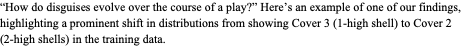
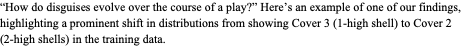
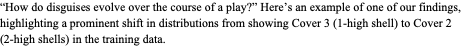
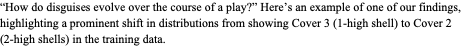